
- 20240536 Inês Jacinto 20240536@novaims.unl.pt
- 20240561 Antônio Ramos 20240561@novaims.unl.pt 
- 20240598 Sofia Jacinto 20240598@novaims.unl.pt 
- 20240750 Marisa Marques 20240750@novaims.unl.pt


In [2]:
!pip install xgboost

In [3]:
# General Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn packages
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# embedded methods
from sklearn.linear_model import LassoCV
import scipy.stats as stats
from scipy.stats import chi2_contingency

from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import classification_report, f1_score

from utils_train import *
from utils import *
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Set the reference date
reference_date = pd.to_datetime("2023-01-01")

In [5]:
# Load the training dataset from CSV files
train_df = pd.read_csv("train_data_after_EDA.csv", index_col="Claim Identifier")

In [6]:
# Define categorical, numeric and binary columns in the dataset for targeted processing

numerical_features = [
    "Age at Injury",
    "WCIO Cause of Injury Code",
    "WCIO Nature of Injury Code",
    "WCIO Part Of Body Code",
    "Number of Dependents",
    "Years Past Accident",
    "Assembly Years past Accident",
    "Industry Code",
    "Birth Year",
    "Average Weekly Wage",
    "IME-4 Count"
]

categorical_features = [
    "Carrier Name",
    "Carrier Type",
    "County of Injury",
    "District Name",
    "Gender",
    "Medical Fee Region",
    "Zip Code"
]

binary_features = [
    "Attorney/Representative",
    "COVID-19 Indicator",
    "First Hearing Date Occurred",
    "C-2 Date Occurred",
    "C-3 Date Occurred"
]


In [7]:
# Check if expected features (numerical, categorical, binary) are present in train_df
for col in numerical_features+categorical_features+binary_features:
    if col not in train_df.columns:
        print(col)
        
print("-------")

# Check if any extra columns exist in train_df that are not in the expected feature lists
for col in train_df.columns:
    if col not in numerical_features+categorical_features+binary_features:
        print(col)

-------
Accident Date
Alternative Dispute Resolution
Claim Injury Type


In [8]:
# Drop rows with missing values in essential columns for model training
train_df.dropna(subset = ["Accident Date","Years Past Accident","Assembly Years past Accident"], inplace=True)

In [9]:
# Separate features (X) and target variable (y)
X = train_df.drop(["Claim Injury Type","Accident Date","Alternative Dispute Resolution"], axis = 1)
y = train_df["Claim Injury Type"]

In [10]:
# Identify and remove outliers based on Z-scores (values > 3 are considered outliers)
z_scores = np.abs(stats.zscore(train_df[numerical_features]))
outliers = (z_scores > 3).any(axis=1)
train_df_clean = train_df[~outliers]

In [11]:
X_clean = train_df_clean.drop(["Claim Injury Type", "Accident Date", "Alternative Dispute Resolution"], axis=1)
y_clean = train_df_clean["Claim Injury Type"]

# Feature Selection

In [12]:
# Split data into training (90%) and test (10%) sets
X_train_90, X_test, y_train_90, y_test = train_test_split(X,y, test_size = 0.1, random_state = 69, stratify = y, shuffle = True) # 10% of data that the models never saw

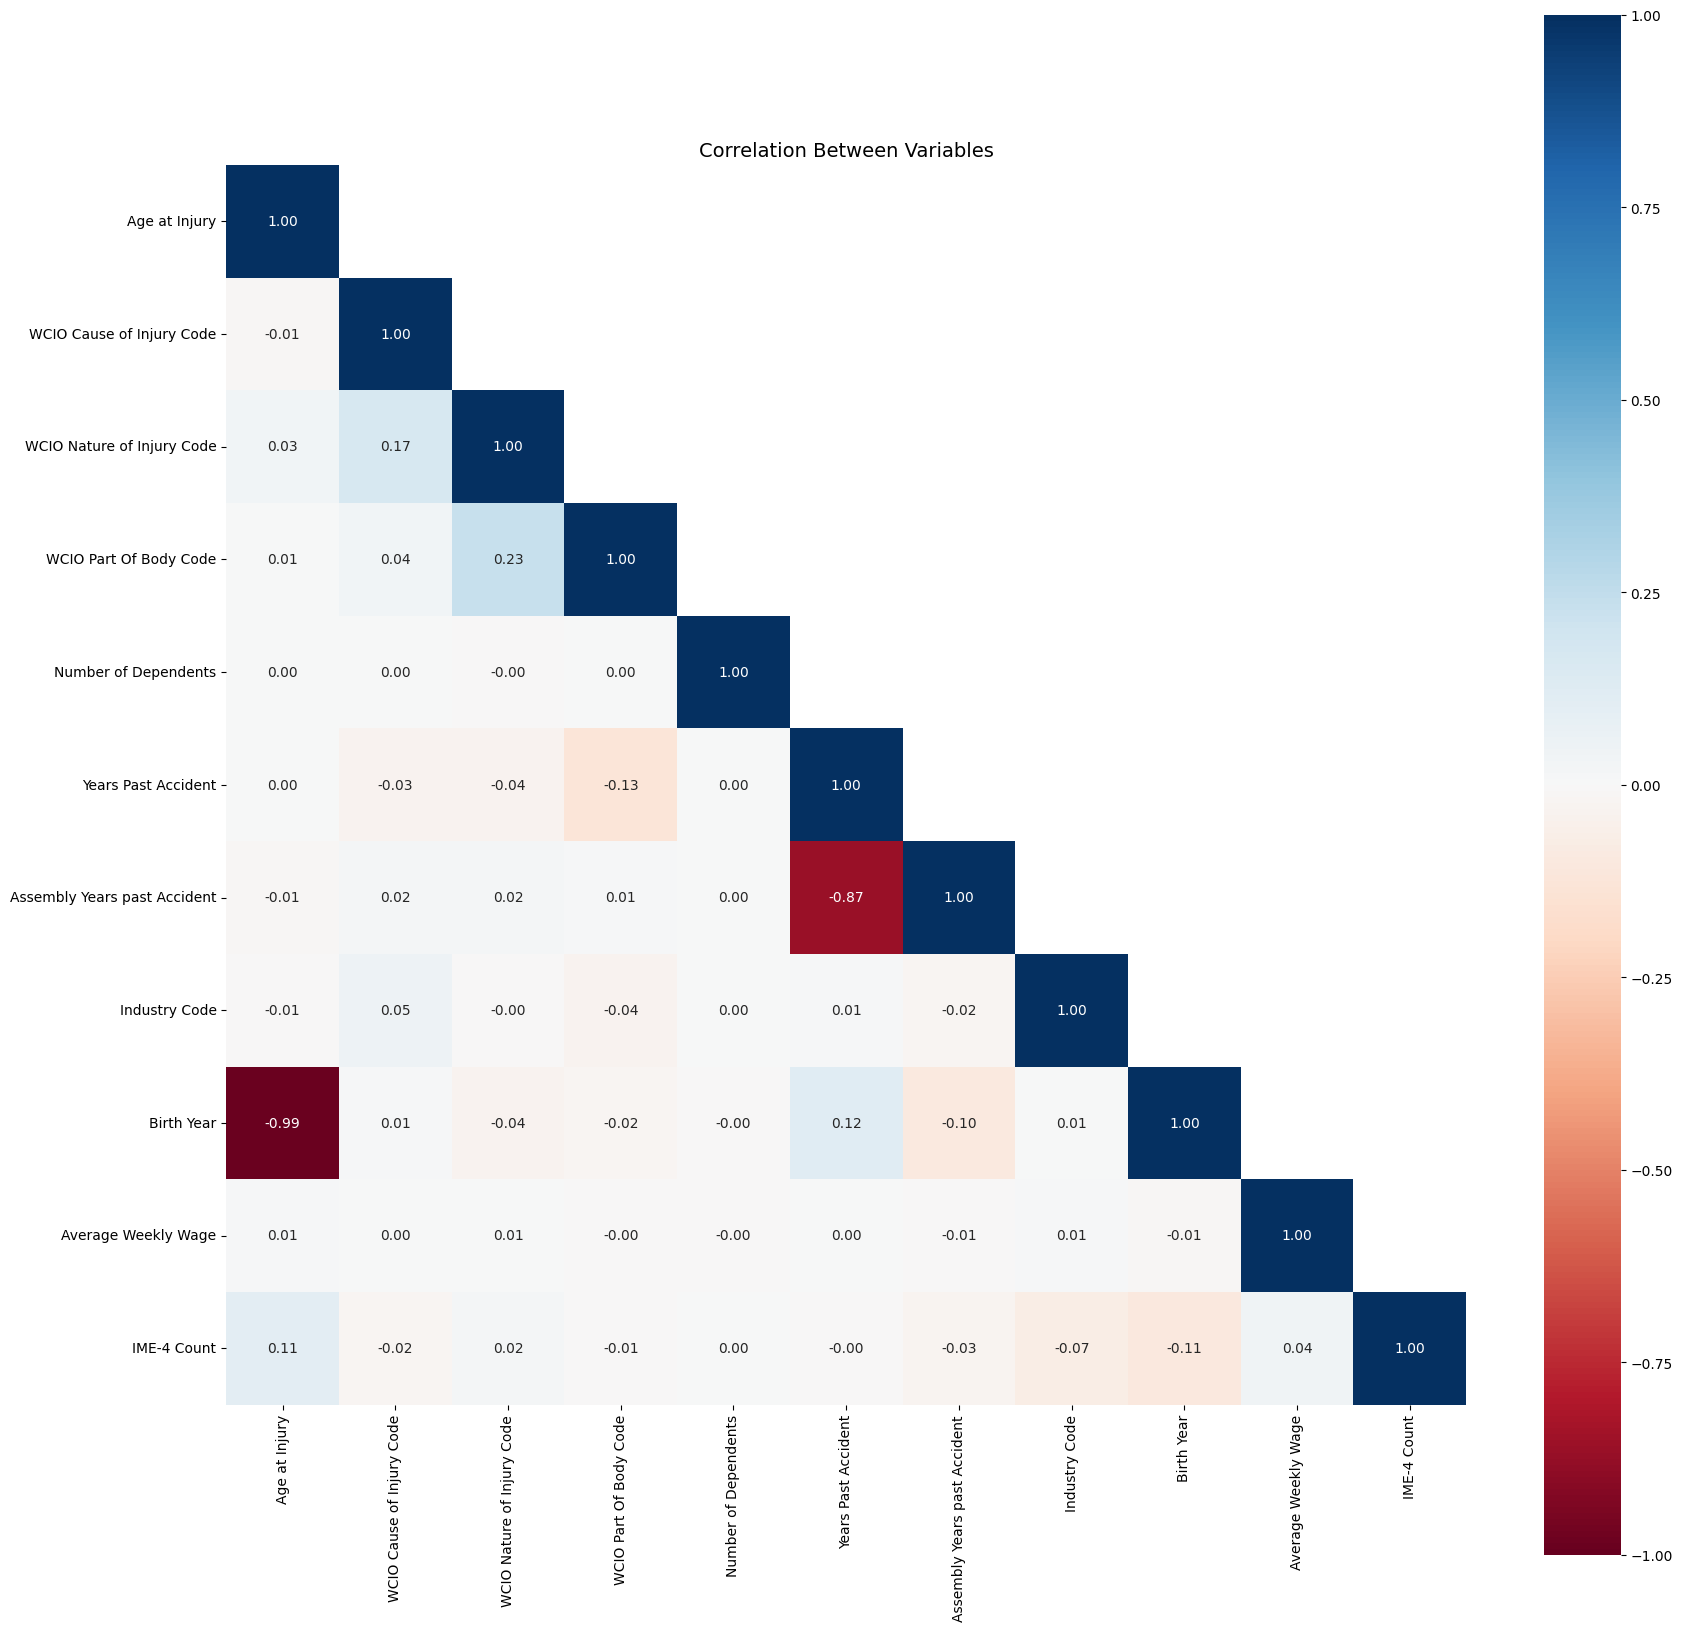

In [13]:
# Compute and visualize the correlation matrix of numerical features
corr_matrix = X_train_90[numerical_features].corr()

# Mask to only show the lower triangle of the correlation matrix
mask = np.tri(*corr_matrix.shape, k=0, dtype=bool)
# Keeps values where mask is True
corr_matrix = corr_matrix.where(mask)

# Defines the figure size
fig, ax = plt.subplots(figsize=(20, 20))

# Heatmap of the initial correlation matrix
l = sns.heatmap(corr_matrix, square=True, annot=True, fmt=".2f", vmax=1, vmin=-1, cmap='RdBu', ax=ax)
plt.title('Correlation Between Variables', size=14)
plt.show()

In [14]:
# Split training data further into training and validation sets
X_train_temp, X_val_temp, y_train_temp, y_val_temp = train_test_split(X_train_90,y_train_90, test_size = 0.25, random_state = 42, stratify = y_train_90, shuffle = True)

In [15]:
# Scale numerical and categorical features for model training
feature_to_scale = numerical_features+categorical_features
mm = MinMaxScaler() # Initialize MinMaxScaler
X_train_temp[feature_to_scale] = mm.fit_transform(X_train_temp[feature_to_scale]) # Fit and transform on train data
X_val_temp[feature_to_scale] = mm.transform(X_val_temp[feature_to_scale]) # Transform on validation data

In [16]:
# Impute missing values in numerical features using KNN imputer
to_impute = ["Average Weekly Wage","Industry Code"]
imputer = KNNImputer(n_neighbors=3)
X_train_temp[to_impute] = imputer.fit_transform(X_train_temp[to_impute])
X_val_temp[to_impute] = imputer.transform(X_val_temp[to_impute])

In [17]:
# Feature selection using Recursive Feature Elimination (RFE) for XGBoost
RFE_XGB_best = feature_selection_RFE(X_train_temp[numerical_features],y_train_temp,n_features=len(numerical_features)
                                    ,model = xgb.XGBClassifier(
                                                    objective='binary:logistic',  
                                                    eval_metric='logloss',         
                                                    use_label_encoder=False,                 
                                                ))

In [18]:
# Feature selection using Recursive Feature Elimination (RFE) for DecisionTree
RFE_DT_best = feature_selection_RFE(X_train_temp[numerical_features],y_train_temp,n_features=len(numerical_features) 
                                    ,model = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, class_weight='balanced'))

In [19]:
RFE_XGB_best

['Age at Injury',
 'WCIO Cause of Injury Code',
 'WCIO Nature of Injury Code',
 'WCIO Part Of Body Code',
 'Years Past Accident',
 'Assembly Years past Accident',
 'Industry Code',
 'Birth Year',
 'Average Weekly Wage',
 'IME-4 Count']

In [20]:
RFE_DT_best

['WCIO Nature of Injury Code', 'Average Weekly Wage', 'IME-4 Count']

In [21]:
# Check for missing values in training set
missing_percentage = X_train_temp.isna().sum() / len(X_train_temp) * 100
for col, percent in missing_percentage.items():
    if not percent == 0:
        print(f"{col}: {percent:.2f}% missing values")

WCIO Cause of Injury Code: 2.25% missing values
WCIO Nature of Injury Code: 2.25% missing values
WCIO Part Of Body Code: 2.44% missing values
Zip Code: 7.64% missing values


In [22]:
# Replace NaNs with the average of each column because of Lasso
X_train_temp[numerical_features] = X_train_temp[numerical_features].fillna(X_train_temp[numerical_features].mean())
X_train_temp['Zip Code'] = X_train_temp['Zip Code'].fillna(X_train_temp['Zip Code'].mean())

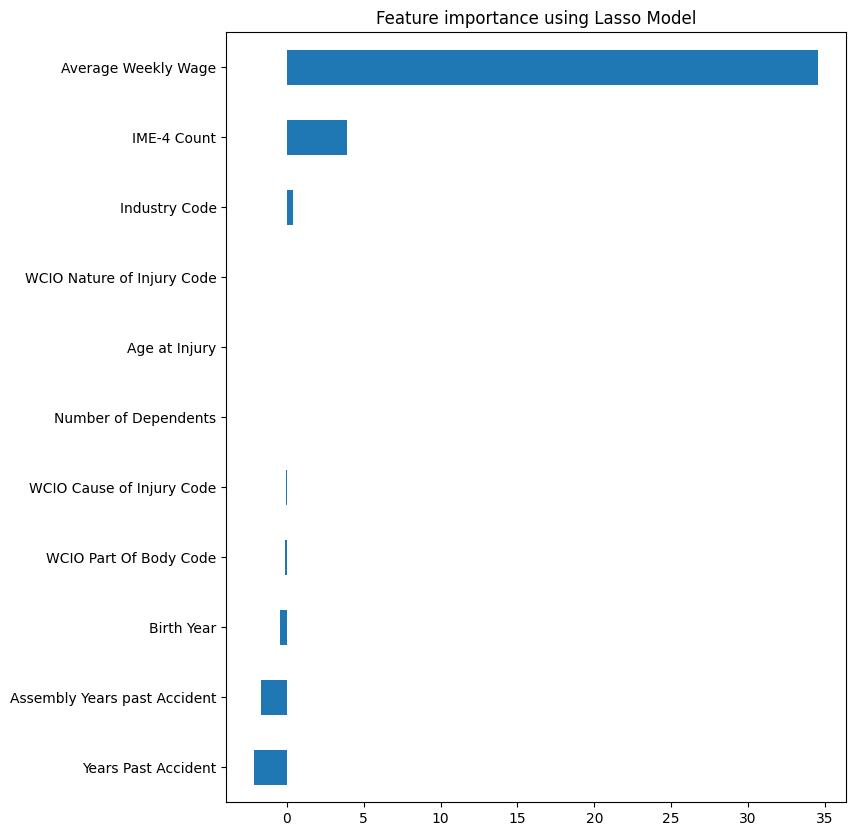

Age at Injury                    0.000000
WCIO Cause of Injury Code       -0.080939
WCIO Nature of Injury Code       0.021770
WCIO Part Of Body Code          -0.113660
Number of Dependents            -0.003928
Years Past Accident             -2.117632
Assembly Years past Accident    -1.705160
Industry Code                    0.375582
Birth Year                      -0.471776
Average Weekly Wage             34.554423
IME-4 Count                      3.928976
dtype: float64


In [23]:
# Perform feature selection using Lasso 
feature_selection_Lasso(X_train_temp[numerical_features],y_train_temp)

In [24]:
# Check independence between features and target (Chi-square test) for categorical and binary features
for col in categorical_features+binary_features:
    TestIndependence(X_train_temp[col],y,col,alpha=0.05)

Carrier Name is IMPORTANT for Prediction
Carrier Type is IMPORTANT for Prediction
County of Injury is IMPORTANT for Prediction
District Name is IMPORTANT for Prediction
Gender is IMPORTANT for Prediction
Medical Fee Region is IMPORTANT for Prediction
Zip Code is IMPORTANT for Prediction
Attorney/Representative is IMPORTANT for Prediction
COVID-19 Indicator is IMPORTANT for Prediction
First Hearing Date Occurred is IMPORTANT for Prediction
C-2 Date Occurred is IMPORTANT for Prediction
C-3 Date Occurred is IMPORTANT for Prediction


<hr>

### Numerical Data

| Predictor | Spearman | RFE XGB| RFE DT | Lasso | What to do? (One possible way to "solve") |
| --- | --- | --- | --- |--- |---|
| Age at Injury | Keep? | Discard | Discard |Discard | Discard |
| IME-4 Count | Keep | Keep | Keep |Keep| Include in the model |
| WCIO Cause of Injury Code | Keep| Keep | Discard | Discard | Try with and without |
| WCIO Nature of Injury Code | Keep | Keep | Keep | Discard | Include in the model |
| WCIO Part Of Body Code | Keep | Keep | Discard | Discard | Try with and without |
| Number of Dependents | Keep | Discard | Discard | Discard | Discard |
| Years Past Accident | Keep | Keep | Discard | Keep | Include in the model |
| Assembly Years past Accident | Discard |Keep |Discart | Keep |  Discard | # Years Past Accident
| Industry Code | Keep |Keep |Discard | Keep |   Include in the model |
| Birth Year | Keep? |Keep |Discard | Keep |  Try with and without |
| Average Weekly Wage | Keep |Keep |Keep | Keep |  Include in the model |

<hr>

### Categorical Data

| Predictor | Chi-Square |
| --- | --- |
| Carrier Name | Keep |  
| Carrier Type | Keep |
| County of Injury| Keep|
| District Name| Keep|
| Gender | Keep |
| Medical Fee Region | Keep |
| Attorney/Representative | Keep |
| COVID-19 Indicator | Keep |
| First Hearing Date Occurred | Keep |
| C-2 Date Occurred | Keep |
| C-3 Date Occurred| Keep |
| Birth Year Occurred | Keep |
| Age at Injury Occurred | Keep |
| Accident Date Occurred | KEEP |

<hr>

# Model Training

In [25]:
# Drop unimportant or redundant features
features_to_drop = ["Number of Dependents","Assembly Years past Accident","Birth Year",
                   "Age at Injury","WCIO Part Of Body Code","WCIO Cause of Injury Code"]
features_to_scale = ["IME-4 Count","WCIO Nature of Injury Code",
                     "Years Past Accident","Industry Code","Average Weekly Wage"] + categorical_features

In [26]:
X_train_90.drop(features_to_drop,axis=1,inplace=True) # Drop unnecessary features

In [27]:
# Print columns after drop
print(X_train_90.columns)
features_to_use = [feature for feature in X_train_90.columns]

Index(['Attorney/Representative', 'Average Weekly Wage', 'Carrier Name',
       'Carrier Type', 'County of Injury', 'COVID-19 Indicator',
       'District Name', 'Gender', 'IME-4 Count', 'Industry Code',
       'Medical Fee Region', 'WCIO Nature of Injury Code', 'Zip Code',
       'Years Past Accident', 'First Hearing Date Occurred',
       'C-2 Date Occurred', 'C-3 Date Occurred'],
      dtype='object')


In [28]:
# Initialize models: XGBoost, RandomForest, and DecisionTree classifiers

XGB = xgb.XGBClassifier(
                model = xgb.XGBClassifier(
                use_label_encoder=False,  
                n_estimators=100, 
                max_depth=6, 
                learning_rate=0.1,        
                random_state=42))

RF = RandomForestClassifier(
    n_estimators=100,         
    max_depth=None,            
    min_samples_split=2,       
    min_samples_leaf=1,        
    random_state=42,           
    n_jobs=-1)

DT = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, random_state=None)

LR = LogisticRegression(
    multi_class='multinomial', 
    max_iter=1000,
    verbose=1, 
    random_state=42)

MLP = MLPClassifier(
    hidden_layer_sizes=(100,),   
    activation='relu',           
    solver='adam',               
    max_iter=200,                
    random_state=42,             
    learning_rate_init=0.001,   
    early_stopping=True,    
    n_iter_no_change=10,         
    tol=1e-4)

In [29]:
#check_performace(XGB,X_train_90,y_train_90,features_to_scale,n_folds = 5)

In [30]:
#check_performace(RF,X_train_90,y_train_90,features_to_scale,n_folds = 5)

In [31]:
#check_performace(DT,X_train_90,y_train_90,features_to_scale,n_folds = 5)

In [32]:
#check_performace(LR,X_train_90,y_train_90,features_to_scale,n_folds = 5)

In [33]:
#check_performace(MLP,X_train_90,y_train_90,features_to_scale,n_folds = 5)

In [34]:
# Split training data into final training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_90,y_train_90, test_size = 0.25, random_state = 42, stratify = y_train_90, shuffle = True)

X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

X_val = X_val.dropna()
y_val = y_val.loc[X_val.index]

# Impute missing values for specific features
to_impute = ["Average Weekly Wage","Industry Code"]
imputer = KNNImputer(n_neighbors=3)
X_train[to_impute] = imputer.fit_transform(X_train[to_impute])
X_val[to_impute] = imputer.transform(X_val[to_impute])

# Apply SMOTE for class balancing
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Scale selected features for training and validation sets
scaler = StandardScaler().fit(X_train[features_to_scale])
X_train[features_to_scale] = scaler.transform(X_train[features_to_scale])
X_val[features_to_scale] = scaler.transform(X_val[features_to_scale])

# Fit models: XGBoost, RandomForest, DecisionTree, LogisticRegression and Multilayer Perceptron
XGB.fit(X_train, y_train)
y_val_XGB_pred = XGB.predict(X_val)

RF.fit(X_train, y_train)
y_val_RF_pred = RF.predict(X_val)

DT.fit(X_train, y_train)
y_val_DT_pred = DT.predict(X_val)

LR.fit(X_train, y_train)
y_val_LR_pred = LR.predict(X_val)

MLP.fit(X_train, y_train)
y_val_MLP_pred = MLP.predict(X_val)

# Evaluate models using f1 score
f1_XGB = f1_score(y_val, y_val_XGB_pred, average='macro')
f1_RF = f1_score(y_val, y_val_RF_pred, average='macro')
f1_DT = f1_score(y_val, y_val_DT_pred, average='macro')
f1_LR = f1_score(y_val, y_val_LR_pred, average='macro')
f1_MLP = f1_score(y_val, y_val_MLP_pred, average='macro')

# Print f1 scores for each model
print(f"Validation XGB f1 score: {f1_XGB}")
print(f"Validation RF f1 score: {f1_RF}")
print(f"Validation DT f1 score: {f1_DT}")
print(f"Validation LR f1 score: {f1_LR}")
print(f"Validation MLP f1 score: {f1_MLP}")


Validation XGB f1 score: 0.377658747042737
Validation RF f1 score: 0.37926842530736143
Validation DT f1 score: 0.2676089219092691
Validation LR f1 score: 0.24443579750026584
Validation MLP f1 score: 0.34156497720969237


In [35]:
# Drop features to match the test data format
X_test.drop(features_to_drop, axis=1, inplace=True)

In [36]:
to_impute = ["Average Weekly Wage","Industry Code"]

# Preprocessing on test data (similar to training data)
X_test[features_to_scale]  = scaler.transform(X_test[features_to_scale]) 
X_test[to_impute] = imputer.transform(X_test[to_impute])

#NAO POSSO FAZER ISTO !!!!!!!!
X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]
#!!!!!!!!!!
#o resto está bem

# Make predictions on the test data using the trained models
XGB_pred = XGB.predict(X_test)
RF_pred = RF.predict(X_test)
DT_pred = DT.predict(X_test)
LR_pred = LR.predict(X_test)
MLP_pred = MLP.predict(X_test)

In [37]:
# Print classification reports for each model's predictions on the test data
print(classification_report(y_test, XGB_pred))

              precision    recall  f1-score   support

           0       0.25      0.20      0.22       445
           1       0.86      0.92      0.89     24802
           2       0.42      0.11      0.17      6097
           3       0.67      0.83      0.74     13158
           4       0.62      0.57      0.59      4295
           5       0.10      0.13      0.11       364
           6       0.00      0.00      0.00         8
           7       0.18      0.54      0.26        37

    accuracy                           0.75     49206
   macro avg       0.39      0.41      0.37     49206
weighted avg       0.72      0.75      0.72     49206



In [38]:
print(classification_report(y_test, RF_pred))

              precision    recall  f1-score   support

           0       0.23      0.11      0.15       445
           1       0.87      0.91      0.89     24802
           2       0.36      0.14      0.20      6097
           3       0.67      0.85      0.75     13158
           4       0.60      0.55      0.58      4295
           5       0.16      0.06      0.09       364
           6       0.00      0.00      0.00         8
           7       0.45      0.35      0.39        37

    accuracy                           0.75     49206
   macro avg       0.42      0.37      0.38     49206
weighted avg       0.72      0.75      0.73     49206



In [39]:
print(classification_report(y_test, DT_pred))

              precision    recall  f1-score   support

           0       0.03      0.49      0.06       445
           1       0.86      0.68      0.76     24802
           2       0.33      0.09      0.15      6097
           3       0.66      0.36      0.47     13158
           4       0.38      0.71      0.50      4295
           5       0.05      0.45      0.08       364
           6       0.00      0.50      0.01         8
           7       0.04      0.73      0.08        37

    accuracy                           0.52     49206
   macro avg       0.30      0.50      0.26     49206
weighted avg       0.69      0.52      0.57     49206



In [40]:
print(classification_report(y_test, LR_pred))

              precision    recall  f1-score   support

           0       0.03      0.55      0.06       445
           1       0.88      0.65      0.75     24802
           2       0.22      0.18      0.20      6097
           3       0.76      0.19      0.30     13158
           4       0.34      0.55      0.42      4295
           5       0.04      0.46      0.07       364
           6       0.00      0.12      0.00         8
           7       0.02      0.81      0.04        37

    accuracy                           0.46     49206
   macro avg       0.29      0.44      0.23     49206
weighted avg       0.70      0.46      0.52     49206



In [41]:
print(classification_report(y_test, MLP_pred))

              precision    recall  f1-score   support

           0       0.08      0.41      0.13       445
           1       0.87      0.84      0.86     24802
           2       0.23      0.17      0.20      6097
           3       0.75      0.66      0.70     13158
           4       0.56      0.52      0.54      4295
           5       0.07      0.52      0.12       364
           6       0.00      0.00      0.00         8
           7       0.07      0.59      0.12        37

    accuracy                           0.67     49206
   macro avg       0.33      0.46      0.33     49206
weighted avg       0.72      0.67      0.69     49206



In [42]:
# Load test data and sample submission file
test_df = pd.read_csv("test_data.csv", index_col="Claim Identifier")
submission = pd.read_csv("sample_submission.csv")

# Initialize a dictionary to store encoding mappings
test_encoder_dict = {}

In [43]:
# Calculate and display the percentage of missing values for each column in the test data
missing_percentage = test_df.isna().sum() / len(test_df) * 100
for col, percent in missing_percentage.items():
    if not percent == 0:
        print(f"{col}: {percent:.2f}% missing values")

Accident Date: 0.63% missing values
Average Weekly Wage: 4.95% missing values
Birth Year: 5.02% missing values
C-2 Date: 2.35% missing values
C-3 Date: 78.04% missing values
First Hearing Date: 88.91% missing values
IME-4 Count: 90.91% missing values
Industry Code: 1.99% missing values
Industry Code Description: 1.99% missing values
OIICS Nature of Injury Description: 100.00% missing values
WCIO Cause of Injury Code: 2.67% missing values
WCIO Cause of Injury Description: 2.67% missing values
WCIO Nature of Injury Code: 2.72% missing values
WCIO Nature of Injury Description: 2.72% missing values
WCIO Part Of Body Code: 2.46% missing values
WCIO Part Of Body Description: 2.46% missing values
Zip Code: 4.99% missing values


In [44]:
# List of categorical features to be encoded using frequency encoding
features_to_encode_freq = ["Carrier Name", "County of Injury", "District Name", "Gender", "Medical Fee Region", "Zip Code"]

# List of binary features to be encoded using binary encoding
features_to_encode_binary = ["Attorney/Representative", "COVID-19 Indicator", "Carrier Type", "Alternative Dispute Resolution"]

# List of descriptive features that provide additional information (e.g., descriptions of injury codes)
features_descriptions = ["Industry Code Description","WCIO Cause of Injury Description", "WCIO Cause of Injury Description",
                        "WCIO Nature of Injury Description", "WCIO Part Of Body Description", "OIICS Nature of Injury Description",
                         "Accident Date"]

# Features that need to be converted into dummy variables (one-hot encoding)
features_to_dummy = ["First Hearing Date", "C-2 Date", "C-3 Date"]

# Features that need to be processed as the number of days from a reference date
features_to_days = ["Assembly Date"]

In [45]:
# Handle missing values in the test data (similar to training data)
test_df["Age at Injury"].fillna(test_df["Age at Injury"].mean(), inplace=True)
test_df['Accident Date'] = pd.to_datetime(test_df['Accident Date'], errors='coerce')
test_df['Birth Year'] = test_df['Birth Year'].fillna(
    test_df['Accident Date'].dt.year - test_df['Age at Injury'])

In [46]:
# Handle anomalies and missing values in specific columns like 'Zip Code'
zip_code_anomalies = test_df[test_df['Zip Code'].notna()  # 'Zip Code' is not missing
        & test_df['Zip Code'].apply(lambda x: not str(x).isnumeric())]  # 'Zip Code' is not numeric

# Replace anomalous zip codes with NaN
test_df.loc[test_df['Zip Code'].isin(zip_code_anomalies['Zip Code']), 'Zip Code'] = np.nan

In [47]:
# Replace 'U' in 'Gender' column (possibly unknown) with 'X'
test_df["Gender"] = test_df["Gender"].replace("U","X")
# Fill missing values in several injury-related columns with 0
test_df["IME-4 Count"].fillna(0,inplace=True)
test_df["WCIO Cause of Injury Code"].fillna(0,inplace=True)
test_df["WCIO Nature of Injury Code"].fillna(0,inplace=True)
test_df["WCIO Part Of Body Code"].fillna(0,inplace=True)
test_df["Zip Code"].fillna(0,inplace=True)
# Create a new feature 'Years Past Accident' by calculating the difference between the accident date and a reference date
test_df["Years Past Accident"] = (pd.to_datetime(test_df["Accident Date"], errors='coerce') - reference_date).dt.days / 365.25

In [48]:
# Cap the 'IME-4 Count' to a maximum of 15 to avoid extreme outliers
test_df.loc[test_df["IME-4 Count"] > 15, "IME-4 Count"] = 15

In [49]:
# Apply frequency and binary encoding to categorical features
multiencoder(test_df, features_to_encode_freq, "frequency", test_encoder_dict)
multiencoder(test_df, features_to_encode_binary, "binary", test_encoder_dict)
# Generate dummy variables for categorical features in 'features_to_dummy'
gen_dummy(test_df,features_to_dummy)
# Process 'features_to_days' to calculate the number of days past a reference date
date_past_accident(test_df, features_to_days)

In [50]:
features_to_drop_test = []

In [51]:
# Identify features to drop from the test data that are not in the list of features to use for modeling
for feature in test_df.columns:
    if feature not in features_to_use:
        features_to_drop_test.append(feature)

In [52]:
# Drop the unnecessary features from the test data
test_df.drop(features_to_drop_test,axis=1,inplace=True)

In [53]:
# Scale the features that require normalization using a previously fitted scaler
test_df[features_to_scale]  = scaler.transform(test_df[features_to_scale])  

In [54]:
# Impute missing values in 'Average Weekly Wage' and 'Industry Code' using a pre-fitted imputer
to_impute = ["Average Weekly Wage","Industry Code"]
test_df[to_impute] = imputer.transform(test_df[to_impute])

In [55]:
# Flag to determine whether to generate a CSV output for submission
make_csv = True

In [56]:
# Mapping of model output classes to human-readable labels
class_mapping = {0: '1. CANCELLED', 1: '2. NON-COMP', 2: '3. MED ONLY', 3: '4. TEMPORARY', 4: '5. PPD SCH LOSS', 5: '6. PPD NSL', 6: '7. PTD', 7: '8. DEATH'}

# Initialize label encoder and assign the class labels based on the mapping
test_encoder = LabelEncoder()
test_encoder.classes_ = np.array(list(class_mapping.values()))

In [57]:
missing_percentage = test_df.isna().sum() / len(test_df) * 100
for col, percent in missing_percentage.items():
    if not percent == 0:
        print(f"{col}: {percent:.2f}% missing values")

Years Past Accident: 0.63% missing values


In [58]:
# Define the model
model = #model
# Make predictions using the trained model on the test data
test_pred = model.predict(test_df)
# Add the predicted 'Claim Injury Type' to the submission dataframe
submission["Claim Injury Type"] = test_pred
# Convert the numerical predicted classes back to their corresponding human-readable labels using the label encoder
submission["Claim Injury Type"] = test_encoder.inverse_transform(submission["Claim Injury Type"])
# If 'make_csv' is True, save the predictions to a CSV file with version control
if make_csv:
    version = version_control("./counter.txt")
    submission.to_csv(f"Group45_Version{version:02}.csv", index=False)

SyntaxError: invalid syntax (4017684266.py, line 2)